In [75]:
# Here we will train a machine learning model using our preprocessed population statistics and road network data
# Typical data processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

In [76]:
# First, let's load our preprocessed data
census2016 = pd.read_csv('./processedData/communityData2016.csv')
census2021 = pd.read_csv('./processedData/communityData2021.csv')
networks = pd.read_csv('./processedData/networkCharacteristics.csv')

In [77]:
# We know what this data looks like from the other journal, but let's print things here for reference
census2016.head()

,GEO_NAME,% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),0 to 4 years,...,Total labour force population aged 15 years and over by occupation - National Occupational Classification (NOC) 2016 - 25% sample data,Total number of census families in private households - 100% data,Total population aged 15 years and over by work activity during the reference year - 25% sample data,Total visible minority population,Two-or-more person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income
0,Saint Martins,10.6,51.1,0.0,0.0,20.0,150.0,195.0,23.1,45.0,...,595.0,360.0,1035.0,0.0,10.0,0.0,90.0,15.0,640.0,345.0
1,St. Martins,NaN,52.9,0.0,NaN,10.0,30.0,40.0,25.0,5.0,...,80.0,75.0,195.0,0.0,5.0,0.0,20.0,25.0,145.0,105.0
2,Simonds,10.1,60.8,11.4,20.0,170.0,655.0,795.0,18.9,195.0,...,2060.0,1240.0,3185.0,35.0,30.0,0.0,245.0,11.9,2295.0,885.0
3,Saint John,14.4,61.3,15.7,36.4,2610.0,10045.0,12040.0,33.6,3245.0,...,34150.0,18730.0,55455.0,4560.0,1505.0,530.0,3285.0,9.6,37170.0,18280.0
4,Musquash,7.4,52.1,0.0,0.0,30.0,180.0,220.0,15.9,60.0,...,595.0,380.0,1010.0,10.0,10.0,0.0,85.0,14.3,705.0,305.0


In [78]:
census2021.head()

,Unnamed: 0,"% of households living in a dwelling provided by the local government, First Nation or Indian band spending more than 30% on shelter costs",% of owner households spending 30% or more of its income on shelter costs,% of owner households with a mortgage,% of tenant households in subsidized housing,% of tenant households spending 30% or more of its income on shelter costs,0 Legislative and senior management occupations,0 to 14 years,0 to 17 years,0 to 17 years (%),...,Total number of census families in private households - 100% data,Total visible minority population,Two-maintainer household,Two-or-more-person non-census-family households,Under 5 years,Unemployed,Unemployment rate,With employment income,Without employment income,GEO_NAME
0,Saint Martins,NaN,5.1,49.0,0.0,0.0,0.0,145.0,170.0,17.0,...,390.0,10.0,265.0,10.0,0.0,85.0,14.0,650.0,385.0,Saint Martins
1,St. Martins,NaN,NaN,52.4,0.0,NaN,0.0,30.0,45.0,NaN,...,90.0,0.0,40.0,0.0,0.0,15.0,13.6,165.0,120.0,St. Martins
2,Simonds,NaN,5.3,58.7,0.0,22.2,0.0,630.0,770.0,11.0,...,1220.0,150.0,700.0,45.0,15.0,215.0,10.6,2300.0,980.0,Simonds
3,Saint John,NaN,11.4,60.7,16.1,27.1,230.0,10180.0,12155.0,24.4,...,18935.0,7405.0,12065.0,1845.0,615.0,3845.0,10.9,38415.0,19610.0,Saint John
4,Musquash,NaN,5.0,57.0,0.0,0.0,0.0,210.0,240.0,8.0,...,395.0,0.0,245.0,20.0,0.0,90.0,14.5,705.0,340.0,Musquash


In [79]:
networks.head()

,Unnamed: 0,Node Connectivity,Betweenness Centrality,Average Node Degree
0,Aberdeen,1,"{1638571580: 0.0, 1638571707: 0.02531645569620...",4.550000
1,Acadieville,1,"{1665424050: 0.0, 1665425717: 0.0, 1665427309:...",4.203390
2,Addington,0,"{604124914: 0.1076792705080486, 1020806170: 0....",5.054902
3,Alma,1,"{16878195: 0.4796404019037546, 857586389: 0.20...",4.063492
4,Alnwick,1,"{1729459293: 0.0, 1729460255: 0.01059597042722...",4.518519


In [80]:
# Note that the counts are different on our datasets. Let's take a subset of the 2021 data that matches 
# the communities in the 2016 data. Note that community name is 'GEO_NAME' in both datasets.
trimmed2021 = census2021[census2021['GEO_NAME'].isin(census2016['GEO_NAME'])]
trimmed2021.info()


<class 'pandas.core.frame.DataFrame'>
Index: 252 entries, 0 to 264
Columns: 264 entries, Unnamed: 0 to GEO_NAME
dtypes: float64(262), object(2)
memory usage: 521.7+ KB


In [81]:
# We have more entries here than in the `2016 data. Let's count the unique values
print(len(trimmed2021['GEO_NAME'].unique()))

218


In [82]:
# Lots of duplicates there. Let's check the 2016 data as well
print(len(census2016['GEO_NAME'].unique()))

234


In [84]:
# No duplicates in the 2016 data, so let's drop the duplicates in the 2021 data and trim out 
# everything except the 2021 population. This will be the y value for our training data.
trimmed2021 = trimmed2021.drop_duplicates(subset='GEO_NAME')
trimmed2021 = trimmed2021[['GEO_NAME', 'Population, 2021']]
trimmed2021.shape

(218, 2)

In [85]:
# Now let's trim the 2016 data to only include what has a match in our trimmed 2021 data
trimmed2016 = census2016[census2016['GEO_NAME'].isin(trimmed2021['GEO_NAME'])]
trimmed2016.shape


(218, 214)

In [90]:
# Now we can train our model. We will use the 2016 data as our X values and the 2021 data as our y values.
from sklearn.model_selection import train_test_split

X = trimmed2016.drop(columns=['GEO_NAME'])
y = trimmed2021['Population, 2021']

# Split the training data into training and validation sets
XTrain, XVal, yTrain, yVal = train_test_split(X, y, test_size=0.2, random_state=314159)

(44,)


In [92]:
# We will use a pipeline to preprocess our data
# All features here are numeric, so we will use a simple imputer to fill in missing values
# and a standard scaler to scale the data
numericTransformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Using most frequent to avoid outliers skewing the data
    ('scaler', StandardScaler())
])

# Setting up the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numericTransformer, X.columns)
    ]
)

In [94]:
# Now we can set up our model
# We'll use a random forest regressor
numberOfTrees = 100
regressor = RandomForestRegressor(n_estimators=numberOfTrees, random_state=314159)
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', regressor)
])


In [96]:
# Train the model
model.fit(XTrain, yTrain)
None

In [99]:
# Predict our values
yPred = model.predict(XVal)

# Calculate the root mean squared error
valRmse = np.sqrt(mean_squared_error(yVal, yPred, squared=False))
# Calculate the R^2 value
valR2 = r2_score(yVal, yPred)

print(f'Validation RMSE: {valRmse}')
print(f'Validation R^2: {valR2}')


Validation RMSE: 11.86272101291597
Validation R^2: 0.9972221472856759


c:\Users\danes\Documents\ACENETMicrocredentialinAdvancedComputing\ISP\CommunityGrowthPrediction\ispEnv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [102]:
# R^2 and RMSE both look good, but let's compare with the mean of the training data
print(f'Mean of validation set: {yTrain.mean()}')
print(f'Validation RMSE as a percentage of the mean: {valRmse / yTrain.mean() * 100}%')

Mean of validation set: 2845.6666666666665
Validation RMSE as a percentage of the mean: 0.4168696619274676%


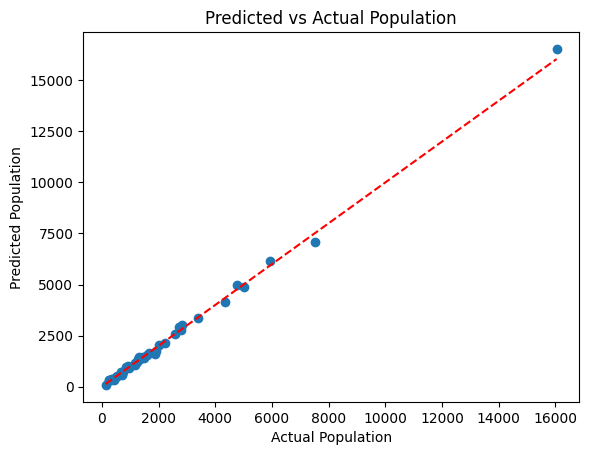

In [105]:
# Let's plot the predicted vs actual values
plt.scatter(yVal, yPred)
# Add a line for perfect correlation
plt.plot([yVal.min(), yVal.max()], [yVal.min(), yVal.max()],  '--', color='red')
plt.xlabel('Actual Population')
plt.ylabel('Predicted Population')
plt.title('Predicted vs Actual Population')
plt.show()


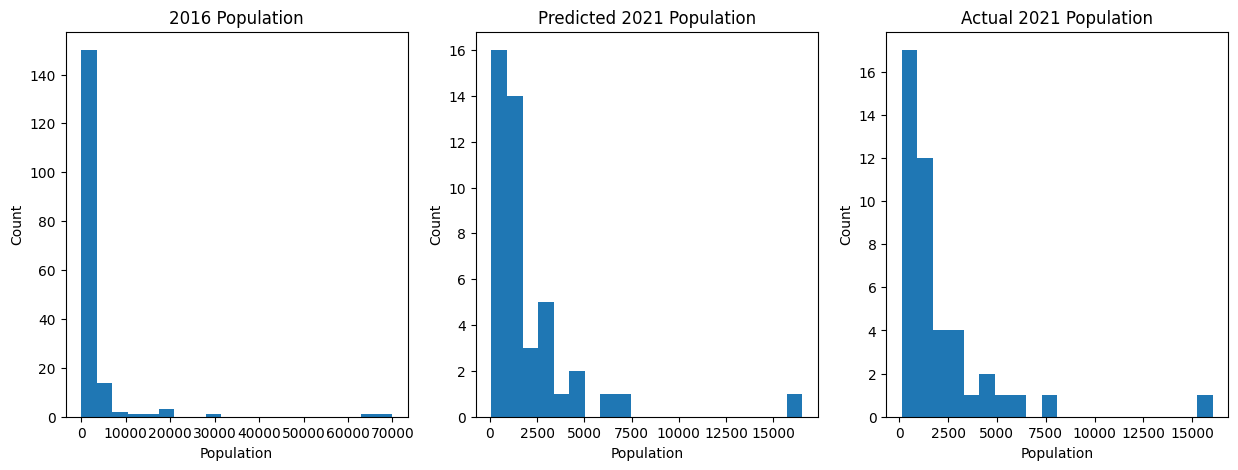

In [111]:
# Let's also plot the 2016 distribution, the predicted distribution, and the actual distribution
# as a set of subplots.
# This will let us see how the communities changed over time
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
dataSets = [yTrain, yPred, yVal]
titles = ['2016 Population', 'Predicted 2021 Population', 'Actual 2021 Population']
for i in range(3):
    axs[i].hist(dataSets[i], bins=20)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Population')
    axs[i].set_ylabel('Count')
plt.show()

